# Innovation in London: Relationship between patents and social spaces


# Import package

Import the software packages used to analysis. The *linearmodels* need to be installed (Version: 6.0)

In [1]:
!pip install linearmodels

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly

from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col

# Packages for panel regression
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import statsmodels.formula.api as smf
from linearmodels.panel import compare
import pysal as ps
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px

from math import ceil

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from esda.adbscan import ADBSCAN

from scipy.cluster.hierarchy import dendrogram

import spopt
from spopt.region import MaxPHeuristic as MaxP

import libpysal
import warnings

from shapely.geometry import Point

warnings.filterwarnings('ignore')
sns.set(font_scale=1.5)
sns.set_style("white")
plt.rcParams['figure.figsize'] = (12, 8)

/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

# Introduction

## Literature review

In recent, there has been a lot of research showing that **innovation** is highly urbanized and concentrated (Balland et al 2020.; Feldman and Kogler, 2010). Clark (2003) considered that Individuals applying for high-tech patents typically reside in areas with more natural and architectural facilities. What’s more, as face-to-face interaction is fundamental to urban innovation (Crookston & Reades 2021), cities help companies and workers become more productive by providing more interactive spaces and increasing the level of ‘economic agglomeration’ (Balland et al 2020). In more detail, meetings between workers at nearby firms raise knowledge spillovers between the firms (Atkin et al 2022), which spurs more creative ideas and then causes more innovations.

In addition, in urban innovation research, innovation is mainly measured by **patents** (Carlino and Kerr, 2015.; Castaldi, 2023.; Chen et al., 2022). However, some studies only consider a portion of innovation types and overlook other forms, such as design and product development. Breznitz (2021) describes this phenomenon as ‘techno-fetishism’, where policymakers tend to only consider the captivating stages of innovation processes. 

Finally, there are several research illustrating the relationship between **interactive spaces** and innovation. For example, Andrews (2019) used the alcohol prohibition to illustrate that during alcohol prohibition, there were an 8-18% reduction in patents per year in the county where it was enforced. In addition, Chen (2022) studied urban vitality (measured by the number of cafes) and population density's impact on innovation (measured by the number of patents). They found that there's a positive relationship between urban vitality and innovation. When the total number of coffee shops increased by 1, the number of applications for creation patents and utility model patents was 3.92 and 7.29, respectively (Chen et al., 2022).

## Research question

Based on the above content, I would like to use the number of pubs to display the interactive space, while the innovation can be measured by all types of patents.
Therefore, this research seeks to investigate whether social spaces such as pubs, can stimulate increased patenting activity in London. Some following research questions include: 

    1.  Is innovation clustered and concentrated in certain areas of the city?
    2.  Are the number of pubs and that of patents relevant at the borough level? 

My overall framework is:

First, I am going to import and wrangle my datasets and visualize them, showing the trends and spatial distribution of the data briefly. Then, I plan to use the **DBSCAN** clustering method to figure out the patent clusters in London. Finally, the **panel regression** can be applied to illustrate the relationship between the number of patents and pubs at the borough level. All the datasets are publicly accessible.


# Data Import and Wrangling

## London shp

First, the London borough dataset can be imported, which is useful for follow-up visualization and summary (by borough). The dataset is open in the London Datastore. Here is the link: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london

In [3]:
# read zip shapefile
# local file read
# London_Borough_path = '../data/London_Borough.zip'
#London_Borough = gpd.read_file('zip://' + London_Borough_path)\

# remote file read
# https://github.com/LiangWeiXian11/lwxDataStoreDS/raw/main/London_Borough.zip
London_Borough_path = 'https://github.com/LiangWeiXian11/lwxDataStoreDS/raw/main/London_Borough.zip'
London_Borough = gpd.read_file(London_Borough_path)
print(London_Borough.head())

                   NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER  SUB_2009  \
0  Kingston upon Thames  E09000021   3726.117       0.000         F       NaN   
1               Croydon  E09000008   8649.441       0.000         F       NaN   
2               Bromley  E09000006  15013.487       0.000         F       NaN   
3              Hounslow  E09000018   5658.541      60.755         F       NaN   
4                Ealing  E09000009   5554.428       0.000         F       NaN   

   SUB_2006                                           geometry  
0       NaN  POLYGON ((516401.600 160201.800, 516407.300 16...  
1       NaN  POLYGON ((535009.200 159504.700, 535005.500 15...  
2       NaN  POLYGON ((540373.600 157530.400, 540361.200 15...  
3       NaN  POLYGON ((521975.800 178100.000, 521967.700 17...  
4       NaN  POLYGON ((510253.500 182881.600, 510249.900 18...  


In [4]:
London_Borough = London_Borough.to_crs('epsg:27700') # There is no 'in_place=True' option here.
print(London_Borough.geometry.crs)

epsg:27700


In [5]:
London_Borough = London_Borough.drop(columns=['HECTARES', 'NONLD_AREA','ONS_INNER','SUB_2009','SUB_2006'])

## Patent city

Then I imported the patent city dataset, which provides information on the UK patent office from 1894 to 2021, and used it as a dependent variable in this research.
The patent city includes the name of each patentee (assignees or inventors), its geocoded address, and when applicable its occupation and citizenship (Bergeaud and Verluise, 2022). This dataset is publicly open and accessed from Harvard Dataverse: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PG6THV

In this research, my interesting columns are:  

    -  publication_date: The date when a patent application is published.
    
    -  is_inv: Whether the patentee (who holds the patent rights) is the inventor. 
    
    -  loc_longitude: longitude of the patents
    
    -  loc_latitude: latitude of the patents
    
The following is an explanation of the data fields: https://cverluise.github.io/patentcity/DATA/

Numerous studies on PatentCity argued that one of the main usages of the dataset is to analyze the geography of innovation (Bergeaud and Verluise, 2024, p. 20). Bergeaud and Verluise also believed that most inventors are expected to be located in metropolitan areas, because Inner London has up to 27% of patentees and only 5% of the population. More importantly, the UK has demonstrated higher data accuracy, with 85% of patent holders having location data accurate to the street or even house number level.

Therefore, the innovation is measured by the number of patents at the borough level.


### (Not essential to run) Output Patents

As patentcity dataset is very large (it is over 900 MB and sometimes it may not load in python), I am going to simplify the dataset by my interesting years (from 2001 to 2021) and coordinates of London. 

In [6]:
# patentcity 
# https://cverluise.github.io/patentcity/DATA/

#patentdf = pd.read_csv('../data/patentcity_v100rc7_000000000000.csv', na_values=[':'], low_memory=False)
#patentdf.head(5)

In [7]:
# select 2001-2021 patents data
#Patents21 = patentdf[(patentdf['publication_date'] >= 20010000) & (patentdf['publication_date'] < 20220000)].copy()

In [8]:
# using approximate London extent to basically reduce the size of dataset.
#LondonPatents21 = Patents21[(Patents21['loc_latitude'] >= 51.1621) & (Patents21['loc_latitude'] <= 51.8446) & (Patents21['loc_longitude'] >= -0.5569)& (Patents21['loc_longitude'] <= 0.3595)].copy()

I then export this data and re-import it again.

In [9]:
# output dataset to reduce loading time.
#LondonPatents21.to_csv('../data/patents/LondonPatent21.csv', index=False)

### New-Patents

Now, the new patent's dataset is smaller (only 2MB) and easy to import and use.

In [10]:
# patentcity 
#New_Patents = pd.read_csv('../data/patents/LondonPatent21.csv', na_values=[':'], low_memory=False)
# https://raw.githubusercontent.com/LiangWeiXian11/lwxDataStoreDS/main/LondonPatent21.csv
New_Patents = pd.read_csv('https://raw.githubusercontent.com/LiangWeiXian11/lwxDataStoreDS/main/LondonPatent21.csv', na_values=[':'], low_memory=False)

It selects specific columns from a DataFrame, adjusts the publication date values, filters rows to include only inventors, and then displays information about the resulting DataFrame.

In [11]:
# columns 
pcColumns = ['publication_date', 'is_inv','loc_longitude', 'loc_latitude']
Patent_columns = New_Patents[pcColumns]
# deal with the date
Patent_columns['publication_date'] = Patent_columns['publication_date']*0.0001
# cut the  and transfer to int (year) directly --
Patent_columns['publication_date'] = Patent_columns['publication_date'].astype(int)
# select inventor
Patent_columns = Patent_columns[Patent_columns['is_inv']==True]
# Patent_columns.sample(5)
Patent_columns.info

<bound method DataFrame.info of       publication_date  is_inv  loc_longitude  loc_latitude
0                 2008    True       0.112710     51.700060
1                 2001    True      -0.342700     51.593030
5                 2013    True      -0.137959     51.520101
6                 2007    True      -0.199632     51.580165
7                 2011    True      -0.511010     51.433460
...                ...     ...            ...           ...
3799              2020    True      -0.341995     51.580559
3802              2013    True      -0.127758     51.507351
3803              2015    True      -0.127758     51.507351
3804              2014    True       0.087806     51.767787
3807              2004    True       0.188750     51.458390

[2354 rows x 4 columns]>

### Patents Select by London Borough

In [12]:
# Create GeoDataFrame (points)
Patent_pois = gpd.GeoDataFrame(Patent_columns, geometry=gpd.points_from_xy(Patent_columns.loc_longitude, Patent_columns.loc_latitude, crs='epsg:4326'))
Patent_pois = Patent_pois.to_crs('epsg:27700') # There is no 'in_place=True' option here.
print(Patent_pois.geometry.crs)

epsg:27700


In [13]:
# use sjoin for spatial join
# 1579 rows × 8 columns
LondonPatent_pois = gpd.sjoin(Patent_pois, London_Borough, how='inner', op='within')
LondonPatent_pois.sample(10)

,publication_date,is_inv,loc_longitude,loc_latitude,geometry,index_right,NAME,GSS_CODE
1509,2018,True,-0.132217,51.522973,POINT (529678.001 182104.002),25,Camden,E09000007
3452,2015,True,-0.127758,51.507351,POINT (530031.780 180374.708),24,Westminster,E09000033
1921,2015,True,-0.262034,51.615786,POINT (520427.052 192203.550),9,Barnet,E09000003
1147,2012,True,-0.127758,51.507351,POINT (530031.780 180374.708),24,Westminster,E09000033
2011,2016,True,-0.127758,51.507351,POINT (530031.780 180374.708),24,Westminster,E09000033
2062,2014,True,-0.169332,51.423163,POINT (527380.805 170939.712),21,Wandsworth,E09000032
2861,2009,True,0.040177,51.481818,POINT (541764.711 177846.919),13,Greenwich,E09000011
2385,2017,True,-0.127758,51.507351,POINT (530031.780 180374.708),24,Westminster,E09000033
1406,2013,True,-0.127758,51.507351,POINT (530031.780 180374.708),24,Westminster,E09000033
1714,2016,True,-0.127758,51.507351,POINT (530031.780 180374.708),24,Westminster,E09000033


## Panel patents data

In [14]:
# set index because panel regression need.
patentPanel=LondonPatent_pois.set_index(['NAME','publication_date']) # set the index to the state code and the year
patentPanel.sample(5)

,,is_inv,loc_longitude,loc_latitude,geometry,index_right,GSS_CODE
NAME,publication_date,,,,,,
Westminster,2007,True,-0.127758,51.507351,POINT (530031.780 180374.708),24,E09000033
Kingston upon Thames,2013,True,-0.302662,51.394010,POINT (518186.205 167474.677),0,E09000021
Westminster,2011,True,-0.127758,51.507351,POINT (530031.780 180374.708),24,E09000033
Camden,2001,True,-0.137959,51.520101,POINT (529287.816 181774.540),25,E09000007
Westminster,2012,True,-0.127758,51.507351,POINT (530031.780 180374.708),24,E09000033


Grouping the DataFrame by 'NAME' and 'publication_date' columns, calculating the size of each group, and resetting index with column name 'patent_count'.

In [15]:
# Grouping
count_by_name_date = patentPanel.groupby(['NAME', 'publication_date']).size().reset_index(name='patent_count')
# 358 rows x 3 columns
count_by_name_date.info

<bound method DataFrame.info of                      NAME  publication_date  patent_count
0    Barking and Dagenham              2001             1
1    Barking and Dagenham              2002             2
2    Barking and Dagenham              2010             1
3    Barking and Dagenham              2011             1
4                  Barnet              2001             3
..                    ...               ...           ...
353           Westminster              2017            69
354           Westminster              2018            70
355           Westminster              2019            45
356           Westminster              2020            26
357           Westminster              2021            11

[358 rows x 3 columns]>

In [16]:
# Merge the result 
patentPanel_count = patentPanel.merge(count_by_name_date, on=['NAME', 'publication_date'], how='left')
patentPanel_count = patentPanel_count.set_index(['NAME','publication_date']) 
# patentPanel_count.head(5)

In [17]:
patentPanel_drop = patentPanel_count[['patent_count']]
patentPanel_new = patentPanel_drop.reset_index()
#patentPanel_new = patentPanel_new.set_index(['NAME'])
patentPanel_new.sample(5)

,NAME,publication_date,patent_count
1407,Enfield,2006,1
1261,Richmond upon Thames,2001,4
507,Westminster,2015,74
445,Westminster,2019,45
1,Harrow,2002,2


Delete duplicate rows because the data here is point features, and most of the data only has different geographic information columns

In [18]:
# Removing duplicate rows where 'publication_date' and 'patent_count' values
patentPanel_unique = patentPanel_new.drop_duplicates(subset=['NAME','publication_date', 'patent_count'])

## London Pub

Finally, I also imported the pub's data which comes from the ONS, a list of UK businesses that is mainly compiled from administrative sources. The data is collected on March 12 of each year from 2001 to 2022, which is also public open. 
The factors of interest in this data are the number of pubs by year and by London borough.

In [19]:
# pubs = pd.read_csv('../data/BarsLondon2022.csv', header = 2,nrows = 109, na_values=[':'], low_memory=False)
# https://raw.githubusercontent.com/LiangWeiXian11/lwxDataStoreDS/main/BarsLondon2022.csv
pubs = pd.read_csv('https://raw.githubusercontent.com/LiangWeiXian11/lwxDataStoreDS/main/BarsLondon2022.csv', header = 2,nrows = 109, na_values=[':'], low_memory=False)

pubs = pubs.drop(0)
# conditions DataFrame -- rows: 108 -> 36 -> 33 
pubs_nums = pubs[(pubs['Number of employees in public house or bar'] == 'Any number of employees') & (pubs['Area name'] != 'United Kingdom') & (pubs['Area name'] != 'England') & (pubs['Area name'] != 'London')]

Then, I link it to the London Borough transfer it to GeoDataFrame for follow-up processes.

In [20]:
Pubs_merge = gpd.GeoDataFrame(London_Borough.merge(pubs_nums, left_on='GSS_CODE', right_on='Area code', how='left'))

In [21]:
Pubs_merge.drop(columns=['2022'], inplace=True)
Pubs_merge.head()

,NAME,GSS_CODE,geometry,Area code,Area name,Number of employees in public house or bar,2001,2002,2003,2004,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Kingston upon Thames,E09000021,"POLYGON ((516401.600 160201.800, 516407.300 16...",E09000021,Kingston upon Thames,Any number of employees,95,100,95,95,...,75,70,70,70,65,65,60,60,60,55
1,Croydon,E09000008,"POLYGON ((535009.200 159504.700, 535005.500 15...",E09000008,Croydon,Any number of employees,165,180,160,155,...,100,95,90,95,90,85,90,80,85,80
2,Bromley,E09000006,"POLYGON ((540373.600 157530.400, 540361.200 15...",E09000006,Bromley,Any number of employees,130,135,130,120,...,105,100,100,110,100,95,105,95,105,105
3,Hounslow,E09000018,"POLYGON ((521975.800 178100.000, 521967.700 17...",E09000018,Hounslow,Any number of employees,130,120,115,115,...,85,85,80,80,75,80,75,70,75,70
4,Ealing,E09000009,"POLYGON ((510253.500 182881.600, 510249.900 18...",E09000009,Ealing,Any number of employees,145,150,135,125,...,100,100,100,115,100,95,95,90,85,85


# Data pre-processing

## Patent city data

When it comes to patent city data, I would like to visualize the spatial distribution of the patent data in 2001, 2011, and 2021 respectively. Besides, I've encapsulated the borough summary and the mapping code as functions, which is easy to call multiple times subsequently. 

We can see the maximum in Westminister in this period, while the numbers of patents are also high in the northeast between 2001 and 2011. However, in 2021, the number of patents is quite low, showing a slump in innovation.

In [22]:
def plot_patents_map(patentsData, year):    
    fig, ax = plt.subplots(figsize=(10, 8))
    # same color range ; make sure  (0,500)
    patentsData.plot(ax=ax, column='patent_count', cmap='Blues', edgecolor='black', legend=True)
    ax.set_title('Number of patents in London Boroughs in ' + str(year) , fontsize=16)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    plt.tight_layout()

    colorbar = ax.get_figure().get_axes()[1]
    colorbar.set_ylabel('Patent Count', fontsize=14)

    for idx, row in patentsData.iterrows():
        centroid = row['geometry'].centroid
        ax.text(centroid.x, centroid.y, str(row['patent_count']), fontsize=10, ha='center', va='center')
        # ax.text(centroid.x, centroid.y, f"{row['NAME']}:{row['patent_count']}", fontsize=8, ha='center', va='center')

    plt.show()

def sum_patents_borough(LondonPatent_pois, London_Borough, year):
    Patent_pois = LondonPatent_pois[LondonPatent_pois['publication_date'] == year]
    # sum total numbers by each borough
    Sum_Patent = London_Borough.copy()
    borough_point_counts = Patent_pois.groupby('NAME').size()
    Sum_Patent['patent_count'] = London_Borough['NAME'].map(borough_point_counts)
    Sum_Patent['patent_count'].fillna(0, inplace=True)
    # transfer
    Sum_Patent['patent_count'] = Sum_Patent['patent_count'].astype(int)
    return Sum_Patent

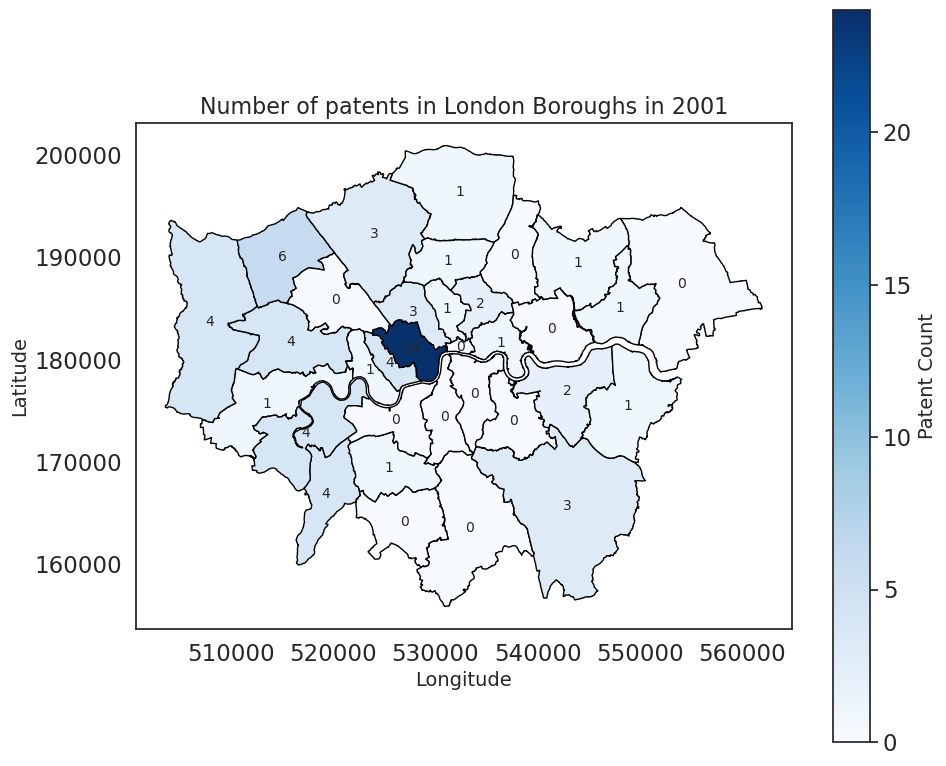

In [23]:
# 2001
year = 2001 
Sum_Patent_2001 = sum_patents_borough(LondonPatent_pois, London_Borough, year)
plot_patents_map(Sum_Patent_2001,year)

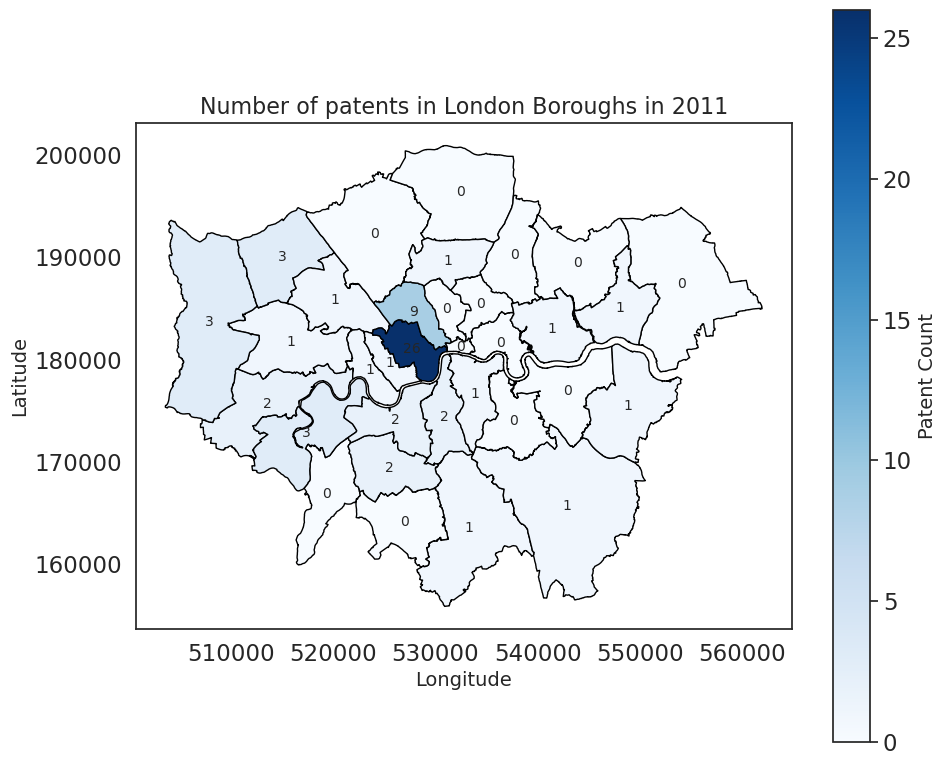

In [24]:
# 2011
year = 2011 
Sum_Patent_2011 = sum_patents_borough(LondonPatent_pois, London_Borough, year)
Sum_Patent_2011
plot_patents_map(Sum_Patent_2011,year)

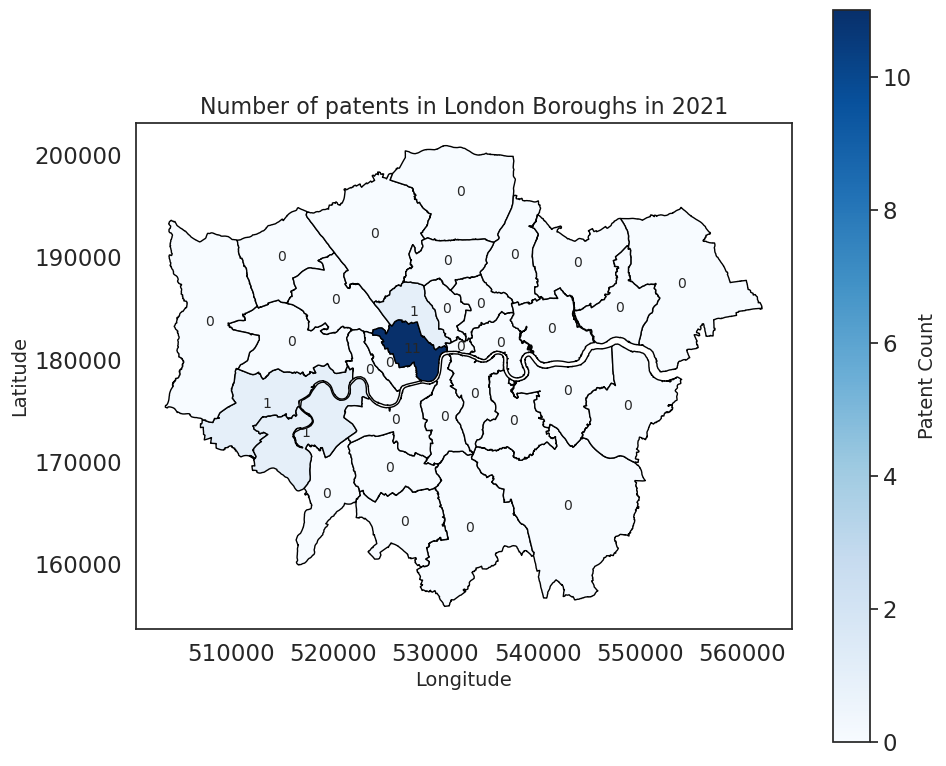

In [25]:
# 2021
year = 2021 
Sum_Patent_2021 = sum_patents_borough(LondonPatent_pois, London_Borough, year)
plot_patents_map(Sum_Patent_2021,year)

## Pubs data

As for the pub data, the maps below show how the number of pubs in London has changed over the past twenty years. The decrease in the number of pubs is particularly clear in some outer London boroughs. For example, the combined number of pubs in the northeast almost halved from around 260 in 2001 to around 135 in 2021. 

In [26]:
# transfer to long data 
pubs_long = pd.melt(Pubs_merge, id_vars = ['NAME','GSS_CODE','geometry', 'Area code','Area name','Number of employees in public house or bar' ], var_name='year', value_name='value')
pubs_long['year'] = pubs_long['year'].astype(int)
pubs_long['value'] = pubs_long['value'].astype(int)

Customize the color range (0-500) to ensure consistent color and value relationships across different years (coloring entirely according to the size of the value).

In [27]:
def plot_pubs_map(pubsData, year):
   
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # same color range ; make sure  (0,500)
    pubsData.plot(ax=ax, column='value', cmap='Blues', edgecolor='black', legend=True, vmin=0, vmax=500)
   
    ax.set_title('Number of pubs in London Boroughs in ' + str(year) , fontsize=16)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    plt.tight_layout()

    colorbar = ax.get_figure().get_axes()[1]
    colorbar.set_ylabel('pub Count', fontsize=14)

    for idx, row in pubsData.iterrows():
        centroid = row['geometry'].centroid
        ax.text(centroid.x, centroid.y, str(row['value']), fontsize=10, ha='center', va='center')
        # ax.text(centroid.x, centroid.y, f"{row['NAME']}:{row['value']}", fontsize=8, ha='center', va='center')
    
    plt.show()

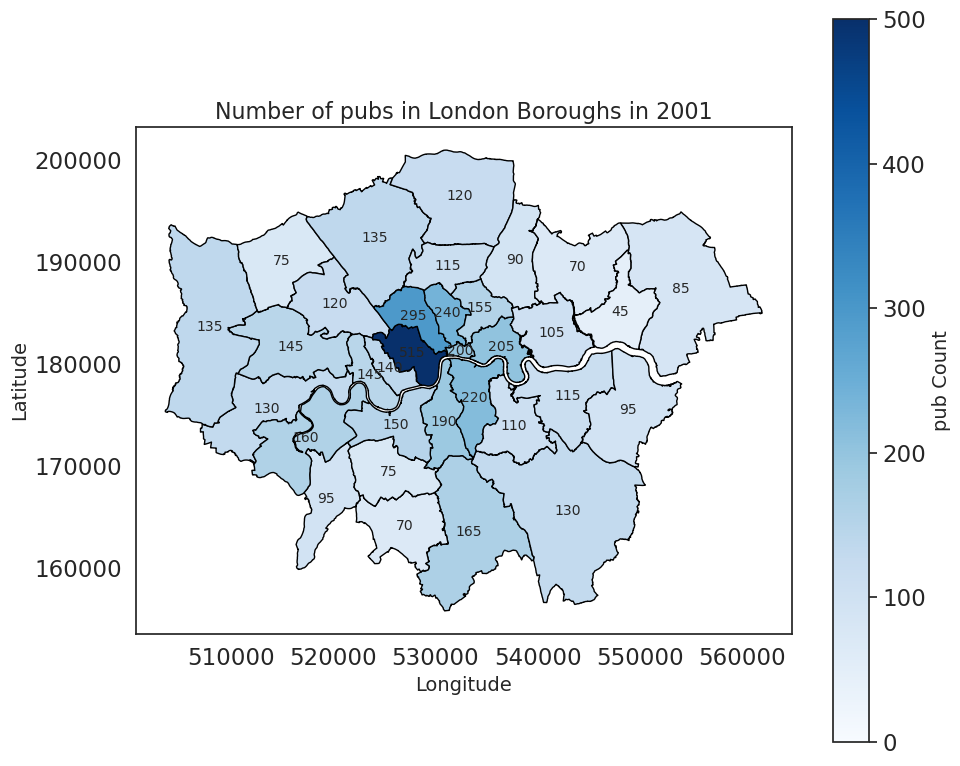

In [28]:
# pubs 2001
year = 2001
plot_pubs_map(pubs_long[pubs_long['year'] == year], year)

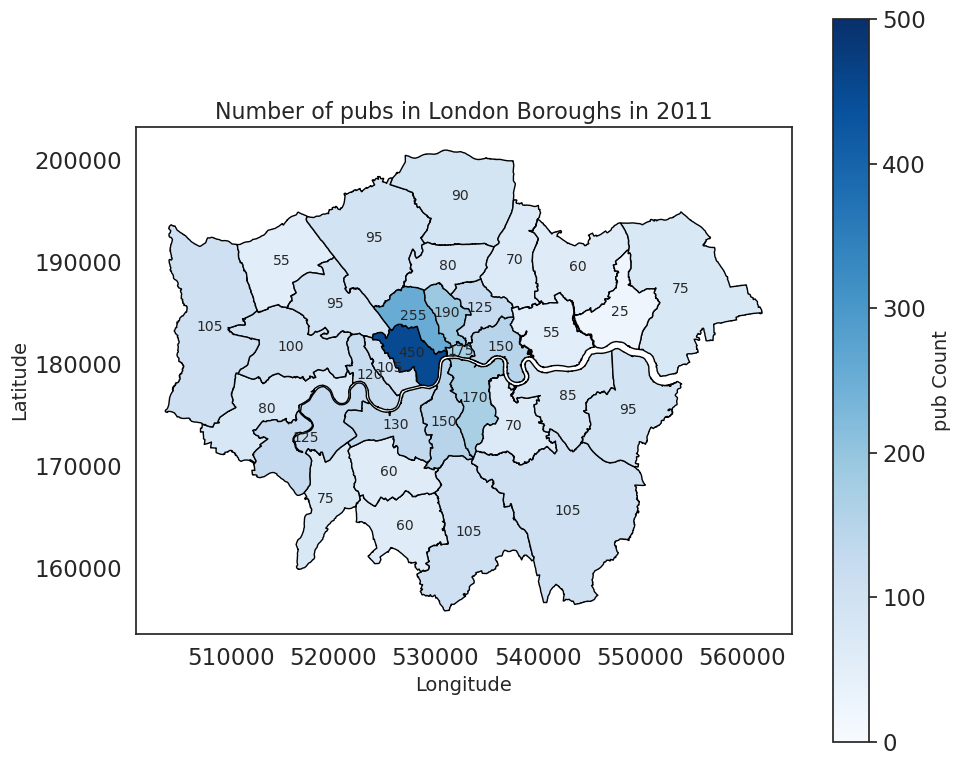

In [29]:
# pubs 2011
year = 2011
plot_pubs_map(pubs_long[pubs_long['year'] == year], year)

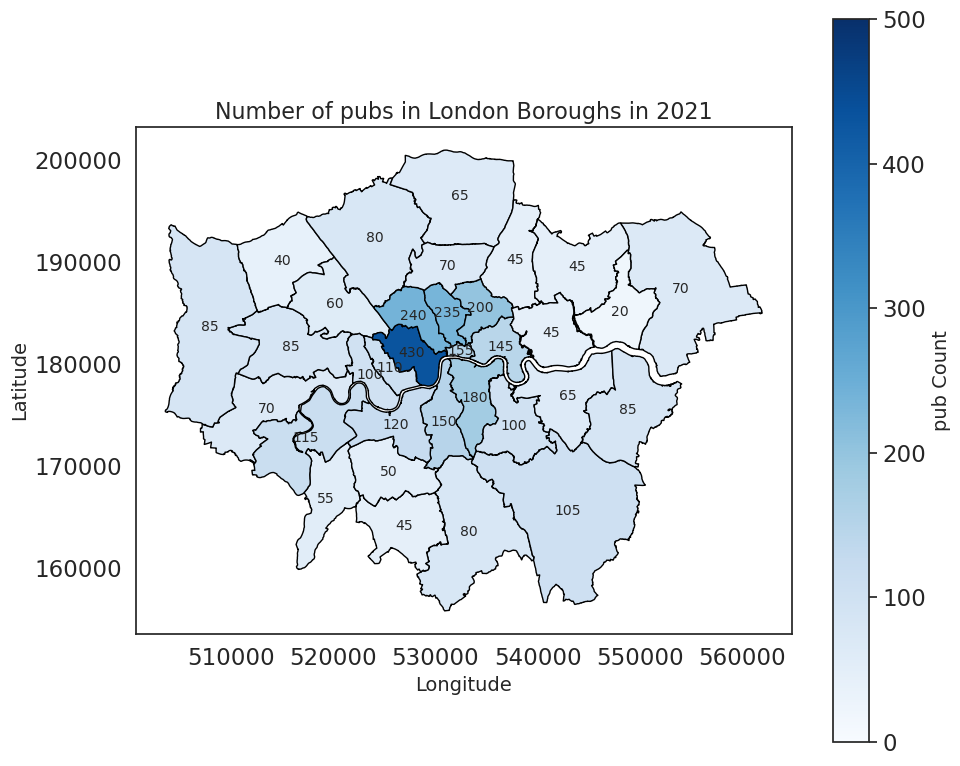

In [30]:
# pubs 2021
year = 2021
plot_pubs_map(pubs_long[pubs_long['year'] == year], year)

# DBSCAN

I am trying to identify clusters in 2001, 2011, and 2021 using patent data. 

If patents are defined as points on a map, some spatial analysis methods can be applied to search for cluster data such as DBSCAB, a density-based method (Ester et al., 1996). DBSCAN is more suitable compared with other clustering algorithms like k-means because it doesn't need to specify the number of clusters before using it (Dennett and Page, 2017). 

In this method, the required parameters include the radius parameter, which defines the radius of the neighborhood, and the minimum number of points within a clustered neighborhood. Therefore, considering my input data from each year and my research area, I defined the minimum points and the epsilon parameters are 4 and 0.03 respectively. 

## Run DBSCAN

In order to visualise and interpret the clusters, the *‘mapping_clusters’* function was constructed.

In [31]:
def mapping_clusters(labels_cluster):
    fig, ax = plt.subplots()
    London_Borough.plot(ax=ax, color='black', alpha=0.5);
    Patent_pois_year['cluster_nm'] = labels_cluster
    Patent_pois_year.plot(ax=ax, column='cluster_nm', categorical=True, legend=True, figsize=(8,6), cmap='Paired',markersize=40);
    plt.show()

### Run DBSCAN in 2001

In [32]:
year = 2001
Patent_pois_year = LondonPatent_pois[LondonPatent_pois['publication_date'] == year]
patents_poi = Patent_pois_year[['loc_longitude','loc_latitude']]
# parameters 
minPts = 4 # 
epsilon = 0.03

dbsc = DBSCAN(eps=epsilon, min_samples=minPts, metric = 'haversine')
# normed 
dbsc.fit(patents_poi)
pd.Series(dbsc.labels_).value_counts()

-1    36
 1    26
 2     6
 0     5
Name: count, dtype: int64

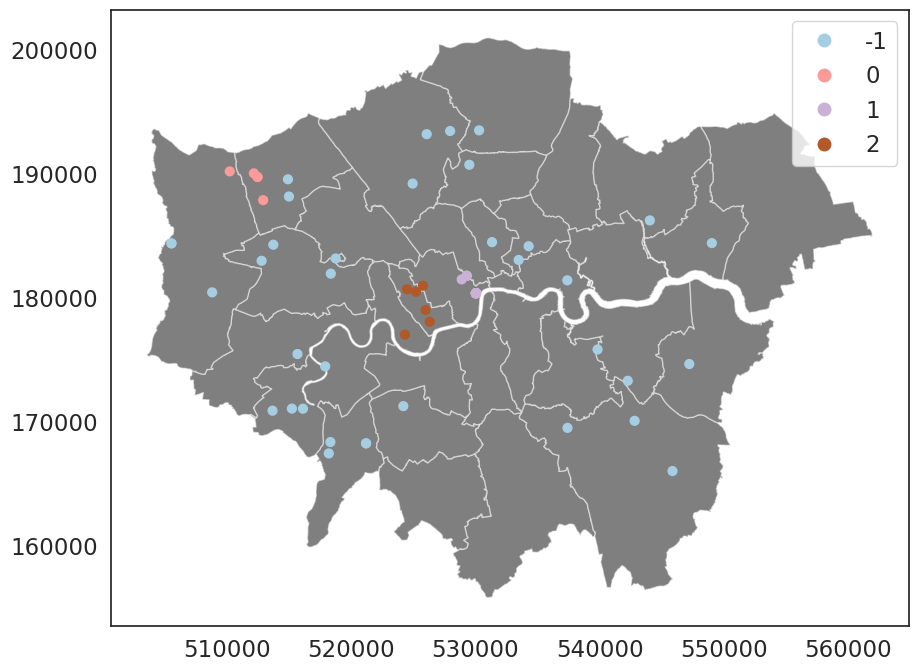

In [33]:
# We now have our DBSCAN object created, and we can extract the groups it has identified. We do this using the `.labels_` method.
cluster_nm = dbsc.labels_
mapping_clusters(cluster_nm)

### Run DBSCAN in 2011

In [34]:
year = 2011
Patent_pois_year = LondonPatent_pois[LondonPatent_pois['publication_date'] == year]
patents_poi = Patent_pois_year[['loc_longitude','loc_latitude']]
# parameters
minPts = 4 # we set minPts as normed.shape[1] + 1 
epsilon = 0.03

dbsc = DBSCAN(eps=epsilon, min_samples=minPts, metric = 'haversine')
# normed 
dbsc.fit(patents_poi)
pd.Series(dbsc.labels_).value_counts()

 0    35
-1    28
Name: count, dtype: int64

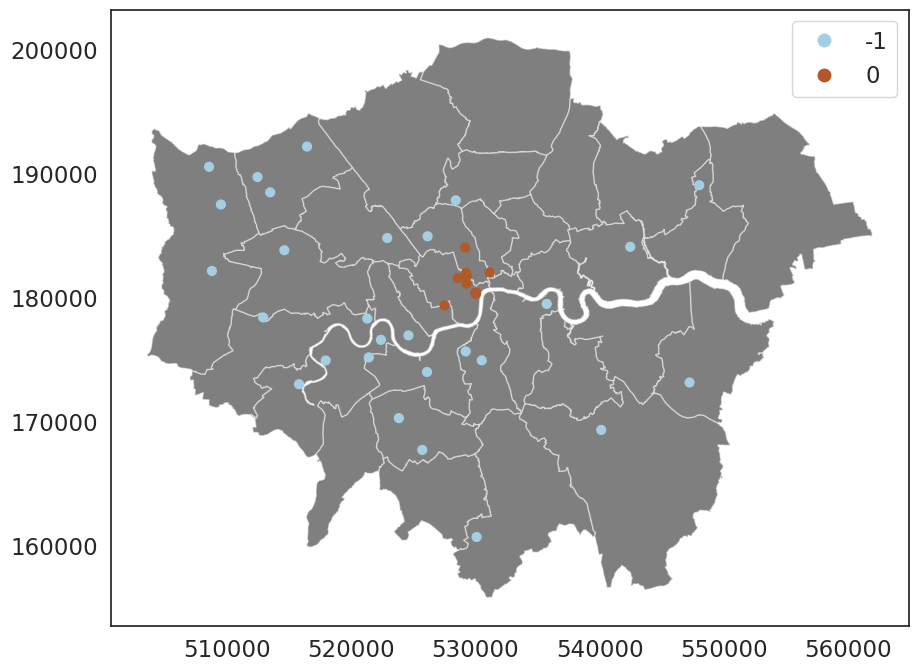

In [35]:
# We now have our DBSCAN object created, and we can extract the groups it has identified. We do this using the `.labels_` method.
cluster_nm = dbsc.labels_
mapping_clusters(cluster_nm)

### Run DBSCAN in 2021

In [36]:
year = 2021
Patent_pois_year = LondonPatent_pois[LondonPatent_pois['publication_date'] == year]
patents_poi = Patent_pois_year[['loc_longitude','loc_latitude']]
# parameters 
minPts = 4 # we set minPts as normed.shape[1] + 1 
epsilon = 0.03

dbsc = DBSCAN(eps=epsilon, min_samples=minPts, metric = 'haversine')
# normed 
dbsc.fit(patents_poi)
pd.Series(dbsc.labels_).value_counts()

 0    12
-1     2
Name: count, dtype: int64

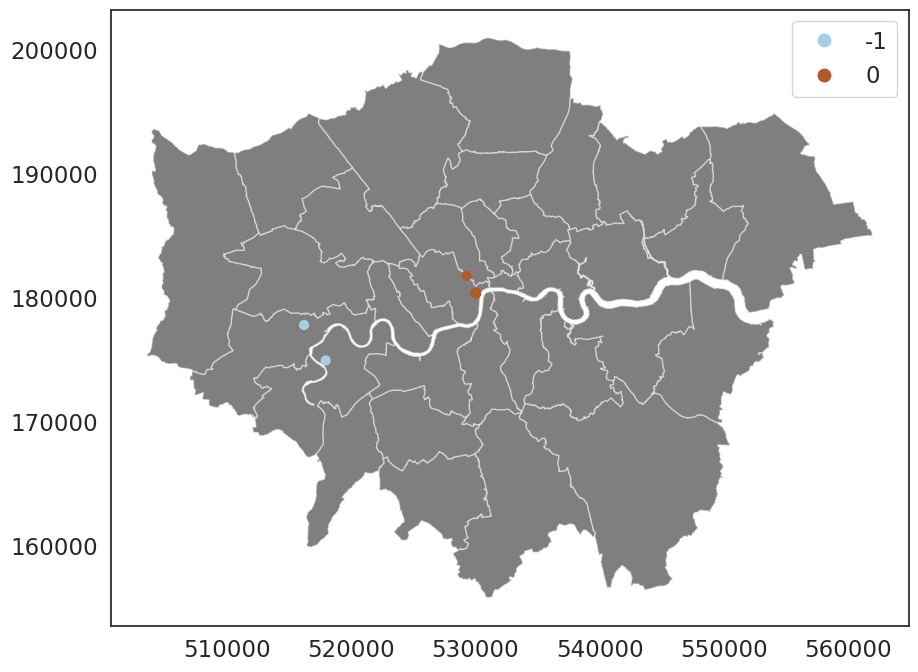

In [37]:
# We now have our DBSCAN object created, and we can extract the groups it has identified. We do this using the `.labels_` method.
cluster_nm = dbsc.labels_
mapping_clusters(cluster_nm)

Based on above analyses, the figure in 2001 shows that there are three different clusters, which are located in the center (clusters 1 and 2) and the northwest (cluster 0) of London. Meanwhile, the number of patents in the cluster 1 was the maximum (26), which are five times more than the other clusters. As for 2011, although there was only one cluster, there were 35 patents in central London, illustrating a high level of aggregation. Finally, only 14 patents occurred in 2021, but it is still a highly concentrated patent cluster with the majority of patenting activity.

Overall, the DBSCAN analyses reveal that patents are not randomly distributed at the London borough level. The patents are clustered in the center of London in 2001, 2011, and 2021, especially in **Westminister**. However, these spatial analyses do not tell us why these agglomerations are occurring, why patents are here, and what factors are contributing to the number of patents sharply decreasing in 2021. Therefore, we stop our spatial analysis here and move to the Panel regression.

# Panel Regression

A fixed-effect panel data model can control for the unobserved time-invariant and city-specific effects (Chen et al., 2022, p. 2). 
I run the panel fixed-effect model to examine the relation between pubs and patents. The model formula is: 

        ‘patentCount ~ 1 + value + TimeEffects’
    
where the ‘patentCount’ and ‘value’ mean the numbers of patents and pubs respectively, while adding 1 in the formula can make sure our result includes the intercept.

## Prepare Panel Data 

In [38]:
# # Converting the data to panel data format with 'Area name' as the index. 
BarPanel=pubs_long.set_index(['Area name']) # set the index to the state code and the year
# Merging two datasets based on 'Area name' and 'year' columns, using left join.
merged_data = pd.merge(BarPanel, patentPanel_unique, left_on=['Area name','year'], right_on=['NAME','publication_date'], how='left')
merged_data.head(5)

,NAME_x,GSS_CODE,geometry,Area code,Number of employees in public house or bar,year,value,NAME_y,publication_date,patent_count
0,Kingston upon Thames,E09000021,"POLYGON ((516401.600 160201.800, 516407.300 16...",E09000021,Any number of employees,2001,95,Kingston upon Thames,2001.0,4.0
1,Croydon,E09000008,"POLYGON ((535009.200 159504.700, 535005.500 15...",E09000008,Any number of employees,2001,165,NaN,NaN,NaN
2,Bromley,E09000006,"POLYGON ((540373.600 157530.400, 540361.200 15...",E09000006,Any number of employees,2001,130,Bromley,2001.0,3.0
3,Hounslow,E09000018,"POLYGON ((521975.800 178100.000, 521967.700 17...",E09000018,Any number of employees,2001,130,Hounslow,2001.0,1.0
4,Ealing,E09000009,"POLYGON ((510253.500 182881.600, 510249.900 18...",E09000009,Any number of employees,2001,145,Ealing,2001.0,4.0


In [39]:
fix_panel_data = merged_data.drop(columns=['NAME_y', 'publication_date','GSS_CODE'])
fix_panel_data.fillna(0, inplace=True)
fix_panel_data['patentCount'] = fix_panel_data['patent_count'].astype(int)
final_panel_data = fix_panel_data.set_index(['NAME_x', 'year'])
final_panel_data.info

<bound method DataFrame.info of                                                                     geometry  \
NAME_x               year                                                      
Kingston upon Thames 2001  POLYGON ((516401.600 160201.800, 516407.300 16...   
Croydon              2001  POLYGON ((535009.200 159504.700, 535005.500 15...   
Bromley              2001  POLYGON ((540373.600 157530.400, 540361.200 15...   
Hounslow             2001  POLYGON ((521975.800 178100.000, 521967.700 17...   
Ealing               2001  POLYGON ((510253.500 182881.600, 510249.900 18...   
...                                                                      ...   
Hackney              2021  POLYGON ((531928.400 187801.500, 531935.700 18...   
Haringey             2021  POLYGON ((531928.400 187801.500, 531919.200 18...   
Newham               2021  MULTIPOLYGON (((544065.000 183254.100, 544062....   
Barking and Dagenham 2021  MULTIPOLYGON (((543905.400 183199.100, 543905....   
City of 

Here, I need to transfer GeoDataFrame to DataFrame, because the panel regression are not able to use GeoDataFrame

In [40]:
bar_patent_Panel_df = final_panel_data.drop(columns=['geometry'])

# transfer GeoDataFrame to DataFrame
bar_patent_Panel_df = bar_patent_Panel_df.reset_index()

print(type(bar_patent_Panel_df))

<class 'pandas.core.frame.DataFrame'>


In [41]:
bar_patent_Paneldata = bar_patent_Panel_df.set_index(['NAME_x','year']) 
# bar_patent_Paneldata.sample(5)

## Run model

The code sets the index for panel data, runs a fixed effects model with 'patentCount' as the dependent variable and 'value' as the independent variable, while controlling for time effects, and prints the model results formatted as a regression table with significance stars.


Adding a constant term (1) allows the model not necessarily to pass through the origin; however, if not included, the model must pass through the origin.

In [42]:
# panel_data=panel_data.set_index(['Area name','year']) # set the index to the state code and the year
# EntityEffects/TimeEffects
panel = PanelOLS.from_formula('patentCount ~ 1 + value + TimeEffects',bar_patent_Paneldata).fit() # run a fixed effects model
print(compare({'Fixed Effects': panel,}, stars=True)) # print the model formatted as a regression table

            Model Comparison           
                          Fixed Effects
---------------------------------------
Dep. Variable               patentCount
Estimator                      PanelOLS
No. Observations                    693
Cov. Est.                    Unadjusted
R-squared                        0.4900
R-Squared (Within)              -0.1729
R-Squared (Between)              0.6341
R-Squared (Overall)              0.4635
F-statistic                      644.58
P-value (F-stat)                 0.0000
=====================     =============
Intercept                    -6.8396***
                              (-16.057)
value                         0.0755***
                               (25.389)
======================= ===============
Effects                            Time
---------------------------------------

T-stats reported in parentheses


The overall R squared is 0.49, while the parameter is 0.0755 between the number of pubs and that of patents. That means the numbers between pubs and patents are positive, although the relationship is not very significant. Meanwhile, as the R squared Within (-0.17) is lower than 0, our model is not good at explaining differences within each borough over time. It may illustrate that the pubs may not be able to capture the changes in patents and there are other variables specific to each borough that are not included in my model, leading to poor explanatory ability within boroughs.

In [43]:
print(panel) # another way to print the model

                          PanelOLS Estimation Summary                           
Dep. Variable:            patentCount   R-squared:                        0.4900
Estimator:                   PanelOLS   R-squared (Between):              0.6341
No. Observations:                 693   R-squared (Within):              -0.1729
Date:                Sun, Apr 21 2024   R-squared (Overall):              0.4635
Time:                        15:30:28   Log-likelihood                   -2217.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      644.58
Entities:                          33   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                   F(1,671)
Min Obs:                       21.000                                           
Max Obs:                       21.000   F-statistic (robust):             644.58
                            

What’s more, as the R squared between is around 0.63, the combination of boroughs and bars can help us understand why certain areas of London more patents have than others, showing some boroughs have more patents compared to others.
In summary, our result does not fully demonstrate a strong positive correlation between the number of pubs and that of patents, but it does provide some evidence that there are spatial distributional differences in patents. 

# Conclusion

In conclusion, we find that the innovation activity is highly concentrated and often clustered in the center of London by studying London between 2001 and 2021. When I used the number of patents and the number of pubs to measure innovation and interaction space in the region respectively, the relationship is positive, although the results are less significant.

There are some discussions including data, model variables, and so on. First, while we can use all types of patents to represent innovation, dividing the different types of patents may help reveal other interesting patterns. In addition, it is not enough to see the full impact of COVID-19 by the patent city dataset in London which was collected in 2021. 

Then, the model does not include enough independent variables such as population density, which may improve my model to capture innovation more accurately. Bettencourt (2007) argued that although there is positively relation between patent application and patent holders’cooperation showing network effects, they are not sufficient to fully explain them.The number of inventors increases significantly with population size (a power law with an exponent larger than unity), while the number of inventions increases only linearly with the number of inventors (Bettencourt et al., 2007, p. 107). Therefore, while collaborative social networks, which embody network effects, can promote innovation, the aggregation effect also affects the number of patents to a certain level by attracting more inventors.

Finally, the panel regression can not address the problem of possible reversed causality. In more detail, areas with high innovation could be more economically dynamic and cause more pubs, such as Westminister. In this case, some studies used the one-year lagged form to deal with this possible issue, which may be the future process of my research.

# References 

Balland, P.-A.; C. Jara-Figueroa; S.G. Petralia; M.P.A. Steijn; D.L. Rigby; and C.A. Hidalgo. 2020. Complex economic activities concentrate in large cities. Nature Human Behaviour

Bergeaud, A., Verluise Cyril, 2022. PatentCity: a dataset to study the location of patents since the 19th century. https://doi.org/10.7910/DVN/PG6THV

Bergeaud, A., Verluise, C., 2024. A new dataset to study a century of innovation in Europe and in the US. Research Policy 53, 104903. https://doi.org/10.1016/j.respol.2023.104903

Bettencourt, L.M.A., Lobo, J., Strumsky, D., 2007. Invention in the city: Increasing returns to patenting as a scaling function of metropolitan size. Research Policy 36, 107–120. https://doi.org/10.1016/j.respol.2006.09.026

Breznitz D (2021) Innovation in Real Places: Strategies for Prosperity in an Unforgiving World. Oxford: Oxford University Press.

Castaldi, C., 2023. The geography of urban innovation beyond patents only: New evidence on large and secondary cities in the United States. Urban Studies 00420980231204718. https://doi.org/10.1177/00420980231204718

Chen, Z., Dong, B., Pei, Q., Zhang, Z., 2022. The impacts of urban vitality and urban density on innovation: Evidence from China’s Greater Bay Area. Habitat International 119, 102490. https://doi.org/10.1016/j.habitatint.2021.102490

Clark, T.N., 2003. 3. URBAN AMENITIES: LAKES, OPERA, AND JUICE BARS: DO THEY DRIVE DEVELOPMENT?, in: Research in Urban Policy. Emerald (MCB UP ), Bingley, pp. 103–140. https://doi.org/10.1016/S1479-3520(03)09003-2\

Dennett, A., Page, S., 2017. The geography of London’s recent beer brewing revolution. Geographical Journal 183, 440–454. https://doi.org/10.1111/geoj.12228

Ester M, Kriegel H-P, Sander J and Xu X 1996 A density-based algorithm for discovering clusters in large spatial databases with noise in KDD-96 Proceedings AAAI Press, Palo Alto CA 226–31

Feldman, Maryann P and Dieter F Kogler, “Stylized facts in the geography of innovation,” in “Handbook of the Economics of Innovation,” Vol. 1, Elsevier, 2010, pp. 381–410.

